# Predicting Coffee Prices Using Random Forest Regression

ABSTRACT

# Part I: Code

### Import libraries

In [1]:
# Preprocessed data
from capstone_modules import Production_Data, Temperature_Data, ICO_Composite_Indicator

# Analysis
import numpy as np
import pandas as pd

# Modeling and statistics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import data

In [2]:
master_dataframe = pd.DataFrame()

# Import production data
production = Production_Data()
ICO_categories = production.ICO_categories
for category in ICO_categories:
    temp_df = production.get_aggregate_production_data_by_ICO_category(category)
    temp_df.name = category + " Production"
    master_dataframe = pd.concat([master_dataframe, temp_df], axis = 1)

# Import ICO composite indicator index data
ICO_composite_indicator = ICO_Composite_Indicator().ICO_indicator_data[["ICO Composite Indicator"]]
    
# Import temperature data
temperature = Temperature_Data()

# Convert master_dataframe to a time series

master_dataframe.index = pd.to_datetime(master_dataframe.index, format = "%Y").values
master_dataframe = master_dataframe.resample("M").bfill()

master_dataframe = ICO_composite_indicator.merge(master_dataframe, left_index = True, right_index = True)

In [24]:
def figure_coffee_production_for_each_ICO_category():
    master_dataframe.drop("ICO Composite Indicator", axis = 1).plot()
    plt.title("Coffee production for each ICO category")
    plt.xlabel("Production year")
    plt.ylabel("Green coffee production (60 kg bags)")
    plt.show()

In [37]:
def figure_ICO_composite_indicator_since_1960():
    total_ICO_composite_indicator = pd.read_csv("../datasets/capstone/ICO composite indicator index since 1960.csv")
    total_ICO_composite_indicator.index = pd.to_datetime(total_ICO_composite_indicator["Unnamed: 0"].values, errors = 'coerce')
    total_ICO_composite_indicator = total_ICO_composite_indicator.drop("Unnamed: 0", axis = 1)
    total_ICO_composite_indicator.columns = ["ICO composite indicator price (¢/lb.)"]

    total_ICO_composite_indicator.plot()
    plt.title("ICO Composite Indicator Prices Since 1960")
    plt.ylabel("ICO composite indicator price (¢/lb.)")
    plt.legend("")
    plt.show()

### Showing distribution of coffee production across countries

In [4]:
production_shares_by_type = production.get_production_share_by_country()[production.get_production_share_by_country()["Market_Year"] > 1989]\
    .pivot_table(values = ["Arabica Production Share", "Robusta Production Share"], index = ["Country"])

def figure_cumulative_production_shares_per_coffee_type_by_country():
    plt.plot(np.cumsum(production_shares_by_type.sort_values("Arabica Production Share", ascending = False)["Arabica Production Share"].values))
    plt.plot(np.cumsum(production_shares_by_type.sort_values("Robusta Production Share", ascending = False)["Robusta Production Share"].values))
    plt.title("Cumulative Production Shares per Coffee Types")
    plt.legend(["Arabica production", "Robusta production"], loc = 'best')
    plt.xlabel("Country index in sorted list")
    plt.show()


This means we can achieve good accuracy if we look at only the top 5-10 countries.

In [5]:
main_arabica_producers = production_shares_by_type.sort_values("Arabica Production Share", ascending = False)["Arabica Production Share"].head(5).index.values
main_robusta_producers = production_shares_by_type.sort_values("Robusta Production Share", ascending = False)["Robusta Production Share"].head(5).index.values


These are the top 5 producers of arabica or robusta coffee

In [6]:
results_top_coffee_producers = list(set().union(main_arabica_producers, main_robusta_producers))
print(results_top_coffee_producers)

["Cote d'Ivoire", 'Indonesia', 'Uganda', 'Vietnam', 'Ethiopia', 'Brazil', 'Mexico', 'Colombia', 'Guatemala']


### Additional feature engineering

In [7]:
test_dataframe = master_dataframe.copy()
for category in production.ICO_categories:
    for country in set().union(main_arabica_producers, main_robusta_producers):
        temp_production_df = production.get_ending_stocks_by_ICO_category(category)[production.get_ending_stocks_by_ICO_category(category)["Country"] == country][["Market_Year","Percent Change"]]
        temp_production_df["Percent Change"] = temp_production_df["Percent Change"].replace(np.inf, np.NaN)
        temp_production_df.columns = ["Market_Year", country + " Ending Stock Percent Change, " + category]
        
        temp_frost_risk_df = temperature.get_temperature_data_by_country(country)[["Frost likelihood"]].resample("M").max()
        temp_frost_risk_df = temp_frost_risk_df[temp_frost_risk_df.index.year >= 1990]
        temp_frost_risk_df.columns = [country + " frost likelihood"]
        
        temp_production_df.index = pd.to_datetime(temp_production_df["Market_Year"].values, format = "%Y")
        temp_production_df = temp_production_df.drop("Market_Year", axis = 'columns')
        temp_production_df = temp_production_df.resample("M").bfill()
        
        temp_production_df = temp_production_df.merge(temp_frost_risk_df, left_index = True, right_index = True)#, left_on = "Market_Year", right_on = "Year", copy = False)
        
        test_dataframe = pd.concat([test_dataframe, temp_production_df], axis = 1)
        
test_dataframe = test_dataframe.dropna(axis = 'columns', thresh = test_dataframe.shape[0] - 1)
test_dataframe = test_dataframe.T.drop_duplicates().T


### Features correlation matrix

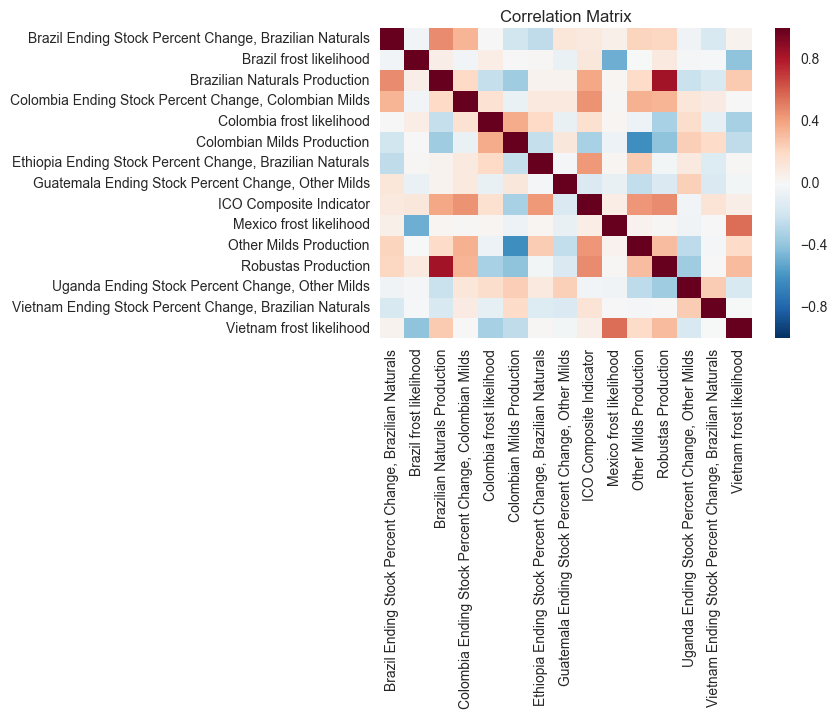

In [8]:
sns.heatmap(test_dataframe.T.drop_duplicates().sort_index().T.corr())
plt.title("Correlation Matrix")
plt.show()


### Showing the distribution of percent changes in ICO Composite Indicator prices

In [9]:
# The percent changes follow a beta distribution

from scipy.stats import beta

ICO_composite_indicator_percent_changes = test_dataframe.ix[1:, "ICO Composite Indicator"].to_frame().pct_change().dropna()
# a, b, loc, scale = beta.fit(ICO_composite_indicator_percent_changes - ICO_composite_indicator_percent_changes.values.min())

def figure_distribution_of_ICO_Composite_Indicator_percent_changes():
    sns.distplot(ICO_composite_indicator_percent_changes.values - ICO_composite_indicator_percent_changes.values.min(), fit = beta, kde = False)
    plt.title("Distribution of ICO Composite Indicator Percent Changes")
    plt.xlabel("ICO Composite Indicator change")
    plt.show()

test_dataframe.ix[1:, "ICO Composite Indicator"].to_frame().pct_change().dropna().describe()


,ICO Composite Indicator
count,322.000000
mean,0.004540
std,0.072377
min,-0.156115
25%,-0.041048
50%,-0.004142
75%,0.039029
max,0.496677


### Principal component analysis

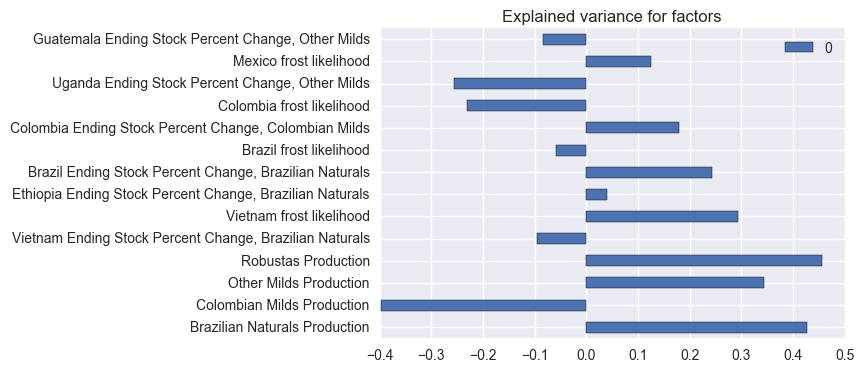

In [10]:
from sklearn.pipeline import Pipeline

pca = PCA()
scaler = StandardScaler()

pca_test_dataframe = test_dataframe[test_dataframe.index.year < 2017].drop("ICO Composite Indicator", axis = 1)
pipe = Pipeline(steps = [("scaler", scaler), ('pca', pca)])

pipe.fit_transform(pca_test_dataframe)

def figure_explained_variance_cumulative_sum():
    plt.plot(np.cumsum(pca.explained_variance_))
    plt.title("Explained Variance for Standardized Features")
    plt.xlabel("Eigenvector index")
    plt.show()


pd.DataFrame(pca.components_[0], index = test_dataframe.drop("ICO Composite Indicator", axis = 1).columns).plot(kind = 'barh')
plt.title("Explained variance for factors")
plt.show()


### Optimized Random Forest Models

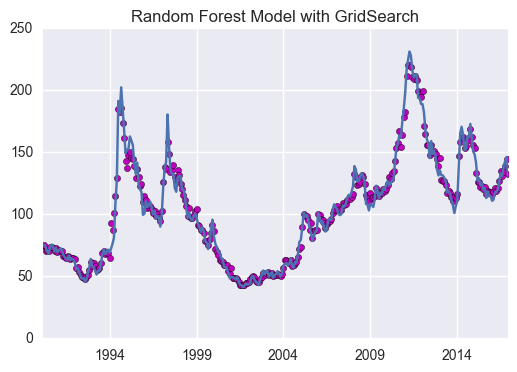

Random forest model score (with GridSearch): 0.9872732694785805


In [15]:
def optimized_random_forest_regression_model(dataframe, show_pre_optimized = False, show_all_predictions = True, months_offset = 1):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-months_offset]
    y = dataframe.ix[months_offset:, "ICO Composite Indicator"]
    
    random_forest_reg = RandomForestRegressor(n_estimators = 200, max_features = "sqrt")

    if show_pre_optimized == True:
        
        train_X, test_X, train_y, test_y = train_test_split(X, y)
        
        random_forest_reg.fit(train_X, train_y)

        y.plot()
        plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
        if show_all_predictions == True:
            plt.scatter(x = y.index, y = random_forest_reg.predict(X), c ="m")
        plt.title("Random Forest Model")
        plt.show()

        print("Random forest model score (pre-GridSearch): {}".format(random_forest_reg.score(X, y)))
        print("Average cross validation score (MSE, pre-GridSearch): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    param_grid_for_gridsearch = {"criterion": ["mse", "mae"], 
                                 "max_features": ["auto", "sqrt", "log2"]}
    gridsearch = GridSearchCV(random_forest_reg, param_grid_for_gridsearch, cv = 10)
    gridsearch.fit(X, y)

    y.plot()
    if show_all_predictions == True:
        plt.scatter(x = y.index, y = gridsearch.predict(X), c ="m")
    plt.title("Random Forest Model with GridSearch")
    plt.show()
    
    print("Random forest model score (with GridSearch): {}".format(gridsearch.score(X, y)))

    
    return gridsearch.best_estimator_
    
random_forest_regressor = optimized_random_forest_regression_model(test_dataframe[test_dataframe.index.year < 2017][1:])


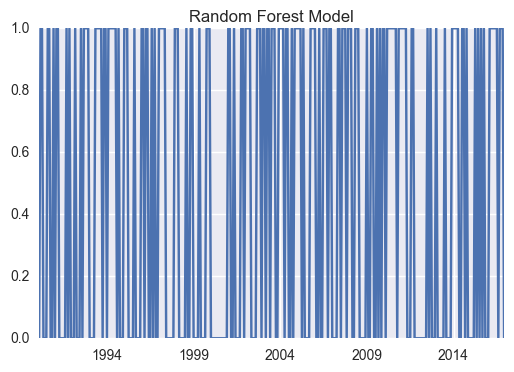

Random forest model score (with GridSearch): 1.0


In [16]:
def random_forest_classifier_with_previous_production_and_ending_stocks(dataframe, show_pre_optimized = False, show_all_predictions = True, months_offset = 1):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-months_offset]
    y = dataframe.ix[months_offset:, "ICO Composite Indicator"]
    
    y_increase = y.to_frame().pct_change() > 0
    y_increase.columns = ["Positive percent change"]
    y_increase = y_increase["Positive percent change"].map({True: 1, False: 0})
    
    random_forest_classifier = RandomForestClassifier(n_estimators = 200, oob_score = True)
    
    if show_pre_optimized == True:
        train_X, test_X, train_y, test_y = train_test_split(X, y_increase)
        
        random_forest_classifier.fit(train_X, train_y)

        y_increase.plot()
        plt.scatter(x = test_y.index, y = random_forest_classifier.predict(test_X), c = "r")
        if show_all_predictions == True:
            plt.scatter(x = y_increase.index, y = random_forest_classifier.predict(X), c = 'm')
        plt.title("Random Forest Classifier Model")
        plt.show()

        print("Baseline predictor: {}".format(y_increase.mean()))
        print("Random forest classifier model score (pre-GridSearch): {}".format(random_forest_classifier.score(X, y_increase)))
        print("Average cross validation score (MSE, pre-GridSearch): {}".format(- cross_val_score(random_forest_classifier, X, y_increase, cv = 10).mean()))
    
    param_grid_for_gridsearch = {"criterion": ["gini", "entropy"], 
                                 "max_features": [None, "sqrt", "log2"]}
    gridsearch = GridSearchCV(random_forest_classifier, param_grid_for_gridsearch, cv = 10)
    gridsearch.fit(X, y_increase)

    y_increase.plot()
    if show_all_predictions == True:
        plt.scatter(x = y_increase.index, y = gridsearch.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score (with GridSearch): {}".format(gridsearch.score(X, y_increase)))
    
    return gridsearch.best_estimator_
        
random_forest_classifier = random_forest_classifier_with_previous_production_and_ending_stocks(test_dataframe, show_all_predictions = False)


### Predictions

In [17]:
print("Regression prediction for {}: {:.2f} cents per pound".format(
    test_dataframe.iloc[-1, 1:].name.strftime("%m-%d-%Y"), random_forest_regressor.predict(test_dataframe.iloc[-1, 1:].values.reshape(1,-1))[0]
    ))

print("Classification prediction for {}: {:.3f} chance of increase".format(
    test_dataframe.iloc[-1, 1:].name.strftime("%m-%d-%Y"), random_forest_classifier.predict_proba(test_dataframe.iloc[-1, 1:].values.reshape(1,-1))[0][1])
)

Regression prediction for 12-31-2016: 128.88 cents per pound
Classification prediction for 12-31-2016: 0.810 chance of increase


In [18]:
def figure_prices_vs_model_for_2013_to_2016():
    test_dataframe.iloc[-48:, 0].plot()
    plt.scatter(x = test_dataframe.iloc[-48:, 0].index.shift(5), y = random_forest_regressor.predict(test_dataframe.iloc[-48:, 1:]), c = 'r')
    plt.title("Optimized Random Forest Regressor Model for 2013 - 2016")
    plt.show()


In [19]:
test_dataframe.shape

(324, 15)

In [20]:
print("Ratio of unique values in dataframe: {:0.3}".format(np.unique(test_dataframe.values.flatten()).shape[0] / test_dataframe.values.flatten().shape[0]))

Ratio of unique values in dataframe: 0.365


# Part II: Report

* Introduction
* Data
* Results
* Discussion
* Next steps


### Introduction

Explain ICO, ICA
Explain ICO composite predictors
Explain major predictors for coffee prices

The nature of the coffee market created a serious complication for analysis. Under the ICA established in 1963, coffee producing countries were regulated by quotas (renewed every five years) which stabilized prices. However the ICO failed agree to new quotas in 1989, causing the quota system to break down, and the pricing system to convert into a free market. This effectively limited the available target data to the period from 1990 to present.

Explain limitations of data: political risk, etc.



Figure 1


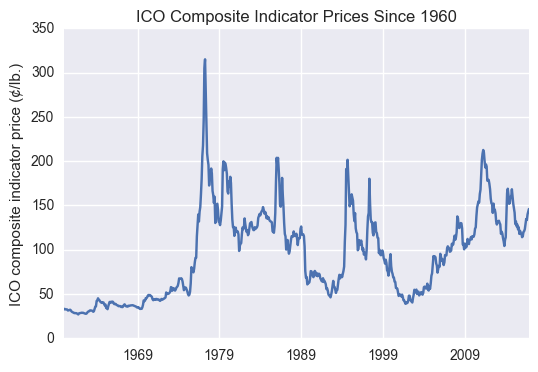

In [41]:
figure_ICO_composite_indicator_since_1960()

### Data

Composite indicator prices were retrieved from the ICO.
Production data was obtained from the US Department of Agriculture's Foreign Agricultural Service, which ...
Temperature data was obtained from Berkeley Earth, which ...

A large and continual complication came from the ICO grouping countries into traditional categories according to the main coffee species produced, and the primary method of processing. (In the dry process, typical of Brazilian and most robusta productions, coffee cherries are washed and dried before hulling. For the wet process, a portion of the fruit is removed immediately after harvesting, while the remaining pulp is removed using a ferment-and-wash method before being fully dried.) 

### Next steps

Precipitation data, which can predict droughts and flooding, was obtained through the National Centers for Environmental Information (an entity within NOAA and under the US Department of Commerce).

In [14]:
%%bash
ls ../datasets/capstone/downloaded\ data

Coffee Producing Countries and Their Harvest Seasons.csv
ICO-composite-indicator-prices-1990-2016--3c - Indicator prices.xlsx
berkeley_earth -- data.txt
berkeley_earth_stations--site_detail.txt
precip.mon.total.1x1.v7.nc
prices-paid-to-growers--ICO 3a - Prices paid to growers.xlsx


In [ ]:
results_top_coffee_producers

In [ ]:
figure_coffee_production_for_each_ICO_category()
figure_cumulative_production_shares_per_coffee_type_by_country()
figure_distribution_of_ICO_Composite_Indicator_percent_changes()
figure_explained_variance_cumulative_sum()
figure_prices_vs_model_for_2013_to_2016()

Next steps: 

* Discuss how far in advance the model can predict within a confidence interval. time before and confidence of cost function
* Tell business angle
* Mention new feature engineering, cost functions

Then look into PCA

See if model-v-actual variance is periodic (i.e., increases each year as months progress from January to February, because of backfilling production data)